# Item analysis - Yelp 2018

This notebook analyses the model performance under different strategies from a item centric point of view.

### Imports

In [1]:
# Module import
from model import LightGCN
from utils import test_minibatch, prepare_dir
from world import FakeArgs, Config
from dataloader import DataLoader
import torch
import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from plotting3 import get_config, get_test_results, count_tp_fn_fp, item_centric_analysis, create_item_centric_plot

### Directory setting

In [2]:
# Ensure the current dir is 'code'
try:
    os.chdir('code')
except FileNotFoundError:
    pass

### Specify the dataset to analyse

In [3]:
# Specify the dataset
dataset = 'yelp2018'

### Set up

In [4]:
# File name map
file_name_map = {
    'original': 'lgn-yelp2018-3-64-original.pth.tar', 
    'weighted item prob': 'lgn-yelp2018-3-64-weigthed_item_prob_sampling.pth.tar', 
    'mixed': 'lgn-yelp2018-3-64-mixed.pth.tar',
}

# Get the config
config = get_config(dataset=dataset)

# Instantiate the DataLoader
data_loader = DataLoader(config)

# Retrieve the training data file
train_df = data_loader.load_train_file()

# Get the number of items in the dataset
n_items = train_df['item_id'].unique().shape[0]

# Obtain a user to item count map
train_df_u_gr = train_df.groupby('user_id')['item_id'].count().reset_index()
train_df_u_sort = train_df_u_gr.sort_values('item_id').reset_index(drop=True)
user_to_item_count_map = dict(zip(train_df_u_sort['user_id'], train_df_u_sort['item_id']))

# Obtain an item to user count map
train_df_i_gr = train_df.groupby('item_id')['user_id'].count().reset_index()
train_df_i_sort = train_df_i_gr.sort_values('user_id').reset_index(drop=True)
item_to_user_count_map = dict(zip(train_df_i_sort['item_id'], train_df_i_sort['user_id']))

loading [../data/yelp2018]
0 training samples and 0 test samples were dropped during the data cleaning.
The user ids were not updated.
The item ids were not updated.
1237259 interactions for training
324147 interactions for testing
yelp2018 Sparsity : 0.0012958757851778647
yelp2018 is ready to go


### Find all the relevant checkpoints and perform analysis

In [5]:
# Create dictionary to store information for each model checkpoint.
catalogue_coverage = {}
item_pivot_gr = {}

# Loop through the checkpoint files
file_list = [f for f in os.listdir('checkpoints/') if f.endswith('.pth.tar') and dataset in f]
for f in file_list:
    # Record time
    start = time.time()
    # Get a list containing the top20 item predictions and the ground truth items for each user
    ground_truth_list, new_rating_list= get_test_results(config, data_loader, file_path=f)
    # Calculate catalogue coverage
    catalogue_coverage[f] = np.round(len(set(torch.concat(new_rating_list).tolist())) / n_items, 3)

    df_analysis = count_tp_fn_fp(ground_truth_list, new_rating_list)
    # user_pivot_gr = user_centric_analysis(df_analysis)
    item_pivot_gr[f] = item_centric_analysis(df_analysis, item_to_user_count_map)

    # Time recording printout.
    print(f'File {f} took: {time.time() - start}')

use NORMAL distribution initilizer
loading adjacency matrix
successfully loaded...
don't split the matrix
lgn is already to go(dropout:0)
load and save to checkpoints/lgn-yelp2018-3-64-weigthed_item_prob_sampling.pth.tar
loaded model weights from checkpoints/lgn-yelp2018-3-64-weigthed_item_prob_sampling.pth.tar
File lgn-yelp2018-3-64-weigthed_item_prob_sampling.pth.tar took: 11.865182876586914
use NORMAL distribution initilizer
loading adjacency matrix
lgn is already to go(dropout:0)
load and save to checkpoints/lgn-yelp2018-3-64-original.pth.tar
loaded model weights from checkpoints/lgn-yelp2018-3-64-original.pth.tar
File lgn-yelp2018-3-64-original.pth.tar took: 10.508851051330566
use NORMAL distribution initilizer
loading adjacency matrix
lgn is already to go(dropout:0)
load and save to checkpoints/lgn-yelp2018-3-64-mixed.pth.tar
loaded model weights from checkpoints/lgn-yelp2018-3-64-mixed.pth.tar
File lgn-yelp2018-3-64-mixed.pth.tar took: 10.667304992675781


### Original results

Plotting item precision and recall by item popularity:


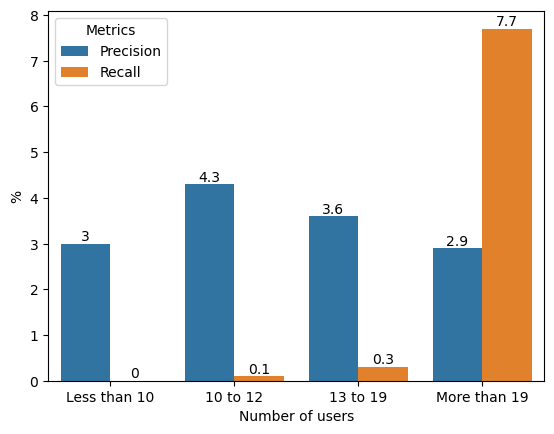

The model achieves a catalogue coverage of 0.385


In [6]:
to_plot = 'original'
file_name = file_name_map[to_plot]
print(f'Plotting item precision and recall by item popularity:')
create_item_centric_plot(item_pivot_gr[file_name], task='plot')
print(f'The model achieves a catalogue coverage of {catalogue_coverage[file_name]*100}%')

Plotting item precision and recall by item popularity:


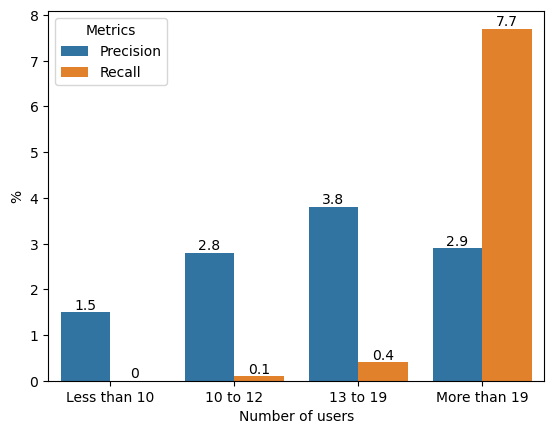

The model achieves a catalogue coverage of 0.39


In [7]:
to_plot = 'weighted item prob'
file_name = file_name_map[to_plot]
print(f'Plotting item precision and recall by item popularity:')
create_item_centric_plot(item_pivot_gr[file_name], task='plot')
print(f'The model achieves a catalogue coverage of {catalogue_coverage[file_name]*100}%')

Plotting item precision and recall by item popularity:


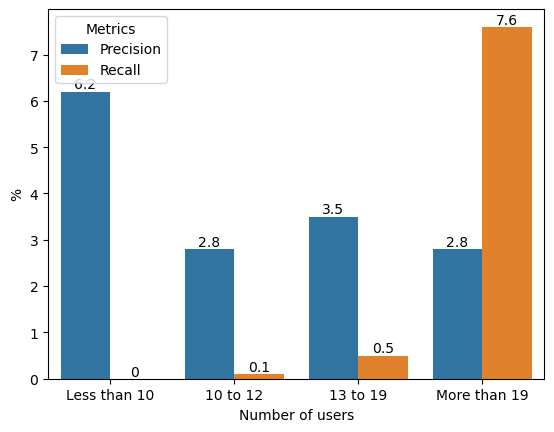

The model achieves a catalogue coverage of 0.429


In [8]:
to_plot = 'mixed'
file_name = file_name_map[to_plot]
print(f'Plotting item precision and recall by item popularity:')
create_item_centric_plot(item_pivot_gr[file_name], task='plot')
print(f'The model achieves a catalogue coverage of {catalogue_coverage[file_name]*100}%')